<h2>Results from varying CH4 and Cl2</h2>

In [7]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib
import types

# Very important line to run the setup notebook!!!
%run do_plot_setup.ipynb
import cl2_utilities as cl2_utils

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

In [14]:
# Load data for the Cl2 sweep trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
exps = ["09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data['experiment_name']=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | # Use exp. with 100 ppm Cl2 tank for Cl2 5-30 ppm and exp. with 1000 ppm Cl2 tank for 45-90 ppm.
                                  (conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']>40)] # Proxy for >=45 ppm is a Cl2 measurement of more than 85mV
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)
current_data.conversion_data = conversion_data
current_data.bypass_data = bypass_data

# Extract the values and 95% CI from the CH4 conversion data
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
cl2_tank_ppms = np.array([1000 if b>40 else 100 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']]) # In this subset of trials, only Cl2 conc's 45 and over used the 1000 ppm tank
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = cl2_utils.get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl2_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

# Save to variable and report success
cl2_sweep_data = current_data
print("Loaded results for plotting into object 'cl2_sweep'.")

Loaded results for plotting into object 'cl2_sweep'.


In [11]:
alternate_properties = {'CH4':{'color':'C0','marker':'.','linestyle':'--','text':'-$\Delta$CH$_4$'},
                      'Cl2':{'color':'g','marker':'.','linestyle':'--','text':'-$\Delta$Cl$_2$'},
                      'CO2':{'color':'xkcd:violet','marker':'.','linestyle':'--','text':'$\Delta$CO$_2$'},
                      'CO':{'color':'xkcd:teal','marker':'.','linestyle':'--','text':'$\Delta$CO',},
                      'CH2O':{'color':'xkcd:navy','marker':'.','linestyle':'--','text':'$\Delta$CH$_2$O'},
                      'C1 Sum':{'color':'xkcd:pink','marker':'.','linestyle':':','text':'$\Delta$CO+$\Delta$CO$_2$+$\Delta$CH$_2$O'},
                      'Cl* Efficiency':{'color':'xkcd:olive','marker':'D','linestyle':':','text':'Cl$^\\bullet_{generated}\div$-$\Delta$CH$_4$'},
                      }

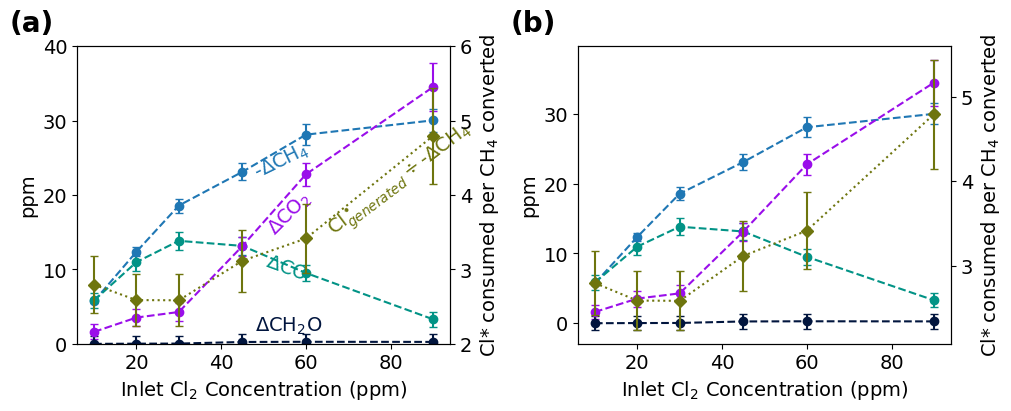

In [17]:
# Global settings
use_error_bars = True

# Set up axes
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width'],4))
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_a_right = ax_a.twinx()
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_b_right = ax_b.twinx()

# Plot the lines and set the axis labels, the same for all axes
for (current_data, current_axis, current_axis_right) in zip((cl2_sweep_data,cl2_sweep_data),(ax_a,ax_b),(ax_a_right,ax_b_right)):
    
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CH4',current_data.inlet_cl2,current_data.ch4_conversions,(current_data.ch4_95_ci if use_error_bars else None))
    #cl2_utils.do_error_bar(current_axis,line_default_properties,'Cl2',current_data.inlet_cl2,current_data.cl2_conversions,(current_data.cl2_conversion_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CO',current_data.inlet_cl2,current_data.co,(current_data.co_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CO2',current_data.inlet_cl2,current_data.co2,(current_data.co2_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis,line_default_properties,'CH2O',current_data.inlet_cl2,current_data.ch2o,(current_data.ch2o_95_ci if use_error_bars else None))
    #cl2_utils.do_error_bar(current_axis,line_default_properties,'C1 Sum',current_data.inlet_cl2,current_data.co_co2_ch2o_sum,(current_data.co_co2_ch2o_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(current_axis_right,alternate_properties,'Cl* Efficiency',current_data.inlet_cl2,current_data.cl_per_ch4,(current_data.cl2_per_ch4_95_ci if use_error_bars else None))

    current_axis.set_ylabel("ppm")
    current_axis.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
    current_axis.xaxis.set_tick_params(labelbottom=True)
    current_axis_right.set_ylabel("Cl* consumed per CH$_4$ converted")
    current_axis_right.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
    current_axis_right.xaxis.set_tick_params(labelbottom=True)

# Manually set axis limits where needed
ax_a.set_ylim(0,40)
ax_a_right.set_ylim(2,6)

# Labeling
labels_a = (('CH4',47,21.5,26),
          ('CO2',50,14,45),
          ('CO',50,8,-20),
          ('CH2O',48,1,0),
          ('Cl* Efficiency',64,13.5,37))
cl2_utils.label_lines(ax_a,alternate_properties,labels_a)

plt.savefig('exported_images/base_case_results.png', bbox_inches='tight',dpi=300)
plt.show()